<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/examples/CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation for Time Series

Cross-Validation is a widely used technique in data science and machine learning. Most common cross-validation methods require shuffling of the data, and this is why those methods are not applicable to time-series data. The nature of time-series data requires a distinct approach to cross-validation.

In this notebook we will give intuition on how time-series cross-validation works. We will be using an example dataset and all the code required to implement the time-series cross-validation with [StatsForecast](https://nixtla.github.io/statsforecast/).

## Installing StatsForecast Library

In [2]:
%%capture
!pip install -U numba
!pip install -U statsmodels
!pip install statsforecast
!pip install neuralforecast

In [3]:
import random
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuralforecast.losses.numpy import mqloss
from sklearn import metrics
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

plt.rcParams["figure.figsize"] = (9,6)

### Auxiliar plot functions

In [21]:
# Auxiliar plot functions
def plot_cv_indices(cv_indices, total_obs, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:gray'}
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv_indices):
        # Fill in indices with the training/test groups
        indices = np.array([2] * total_obs)
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=pd.Series(indices).map(colors),
            marker="_",
            lw=lw,
            # cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Index",
        ylabel="CV iteration",
        ylim=[n_splits, -0.2],
        xlim=[0, total_obs],
    )
    ax.set_title("Cross-validation splits", fontsize=15)
    return ax

def plot_grid(df_train, plot_titles, df_test=None, plot_random=True):
    """Plots multiple time series."""
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train', c='black')
        axes[idx, idy].xaxis.set_tick_params(rotation=45)
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y'], c='black', label='True')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y_5'], c='blue', alpha=0.3)
            axes[idx, idy].plot(test_uid['ds'], test_uid['y_50'], c='blue', label='p50')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y_95'], c='blue', alpha=0.3)
            axes[idx, idy].fill_between(x=test_uid['ds'],
                                        y1=test_uid['y_5'],
                                        y2=test_uid['y_95'],
                                        alpha=0.2, label='p5-p95')
        axes[idx, idy].set_title(f'State: {plot_titles[uid]}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.7)
    plt.show()
  

## Time Series Cross-Validation



In this procedure there is a series of test sets. The corresponding training sets consist only of observations that ocurred prior to the observations from the test set. Thus, no future observations can be used in constructing the forecast. The following diagram illustrates the series of training and test sets, where the blue observations form the training sets, and the orange observations form the test sets. The forecast accuracy is computed by averaging over the test sets.


*Adapted from https://robjhyndman.com/hyndsight/tscv/*

<AxesSubplot:title={'center':'Cross-validation splits'}, xlabel='Index', ylabel='CV iteration'>

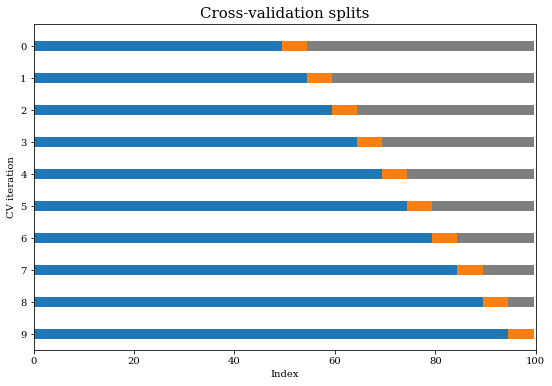

In [5]:
total_obs = 100
nfolds = 10
cv_indices =[]

for i in range(1, nfolds+1)[::-1]:
    cutoff = 100 - i*5
    cv_indices.append((np.array(range(cutoff)), np.array(range(cutoff, cutoff+5))))

fig, ax = plt.subplots()
plot_cv_indices(cv_indices, total_obs, ax, nfolds)

## Loading and Exploring Tourism Data

The dataset we'll be using is a tourism dataset containing quarterly data on the number of trips performed during the time span. The trips are categorized by State, Region and Purpose. We'll be creating predictions at the State level.

In [6]:
data_url = "https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv"
tourism_df = pd.read_csv(data_url, sep=",")
tourism_df.head()

,Quarter,Region,State,Purpose,Trips
0,1998 Q1,Adelaide,South Australia,Business,135.077690
1,1998 Q2,Adelaide,South Australia,Business,109.987316
2,1998 Q3,Adelaide,South Australia,Business,166.034687
3,1998 Q4,Adelaide,South Australia,Business,127.160464
4,1999 Q1,Adelaide,South Australia,Business,137.448533


### Prepare dataset for `StatsForecast` modelling

In [7]:
# Aggregate
target_var = "Trips"
aggregation_vars = ["Quarter", "State"] 
tourism_df_agg = tourism_df[aggregation_vars + [target_var]].groupby(aggregation_vars, as_index=False).sum()

# Create a dict maping string values in Quarter to datetime
quarters = tourism_df["Quarter"].sort_values().unique()
ds = pd.date_range(start='1998-01-01', periods=len(quarters), freq='Q')
ds_quarter = dict(zip(quarters, ds))

# Prepare columns
tourism_df_agg.rename(columns={target_var: 'y'}, inplace=True)
tourism_df_agg["unique_id"] = tourism_df_agg.groupby("State").ngroup()
tourism_df_agg["ds"] = [ds_quarter[q] for q in tourism_df_agg["Quarter"]]

State_id = dict(zip(tourism_df_agg["unique_id"].unique(), tourism_df_agg["State"].unique()))
tourism_df_agg.drop(["Quarter", "State"], axis=1, inplace=True)

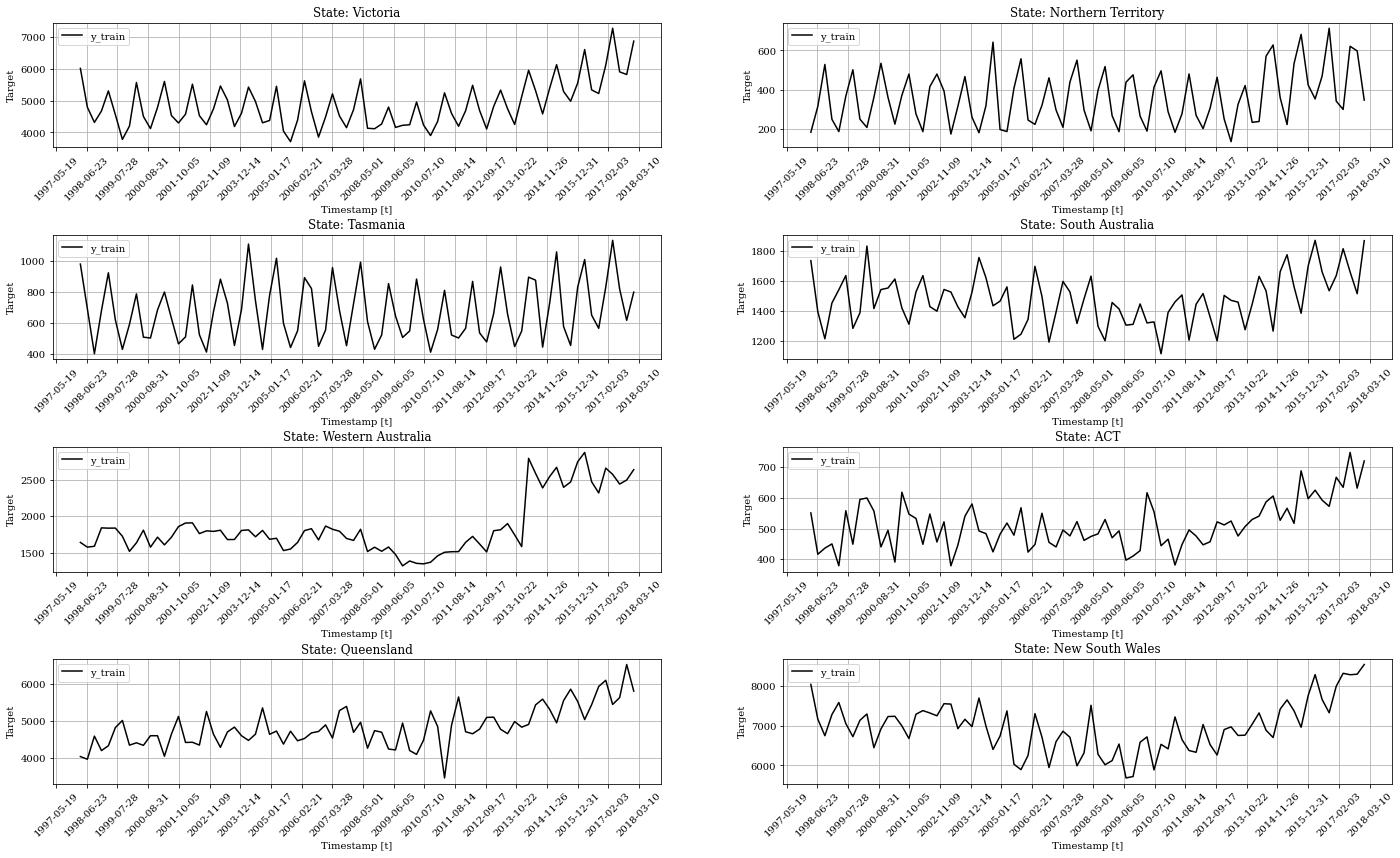

In [8]:
plot_grid(tourism_df_agg, plot_titles=State_id)

## Rolling window ARIMA Predictions

### Perform Cross-Validation

In [9]:
# Modelling parameters
season_length = 4
horizon = 1
freq = "Q"
n_windows_cv = 20

Create forecast object and perform cross validation.

In [25]:
fcst = StatsForecast(
    df=tourism_df_agg, 
    models=[AutoARIMA(season_length=season_length)], 
    freq=freq, 
    n_jobs=-1
)
forecasts_cv = fcst.cross_validation(h=horizon, n_windows=n_windows_cv, level=(90,)) 
forecasts_cv.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,,,
0,2013-03-31,2012-12-31,524.553589,485.676483,382.970947,588.381958
0,2013-06-30,2013-03-31,475.532501,486.325409,384.189240,588.461609
0,2013-09-30,2013-06-30,506.512085,486.145721,384.876953,587.414490
0,2013-12-31,2013-09-30,529.584534,486.476532,385.993347,586.959717
0,2014-03-31,2013-12-31,540.607544,487.153168,387.096008,587.210327


Plot time series CV.

<AxesSubplot:title={'center':'Cross-validation splits'}, xlabel='Index', ylabel='CV iteration'>

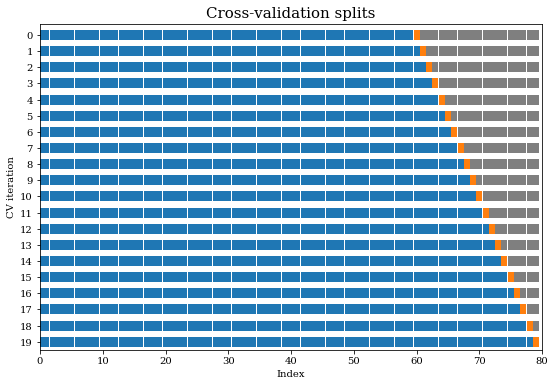

In [26]:
time_cv_indices = [
    (np.where(ds <= cutoff), np.where(ds == cutoff) + np.array(1)) \
    for cutoff in forecasts_cv[forecasts_cv.index == 0]["cutoff"]
]

fig, ax = plt.subplots()
plot_cv_indices(time_cv_indices, tourism_df_agg[tourism_df_agg.unique_id == 0].shape[0], ax, n_windows_cv)

### Quantitative evaluation

For the evaluation we use the Mean Absolute Error:

$$ \mathrm{MAE}(y, \hat{y}) = \frac{1}{N*H} \sum_{i,\tau} |y_{i,\tau}-\hat{y}_{i,\tau}| $$


In [27]:
def compute_MAE(df, model_name):
    return metrics.mean_absolute_error(df["y"], df[model_name])

cutoff_values = forecasts_cv["cutoff"].unique()
cv_MAE = []
for ct in cutoff_values:
    cv_MAE.append(compute_MAE(forecasts_cv[forecasts_cv["cutoff"] == ct], "AutoARIMA"))
print(f"Average Mean Absolute Error across all Cross-Validation folds: {str(np.round(np.mean(cv_MAE), decimals=2))}")

Average Mean Absolute Error across all Cross-Validation folds: 172.65


### Plotting predictions

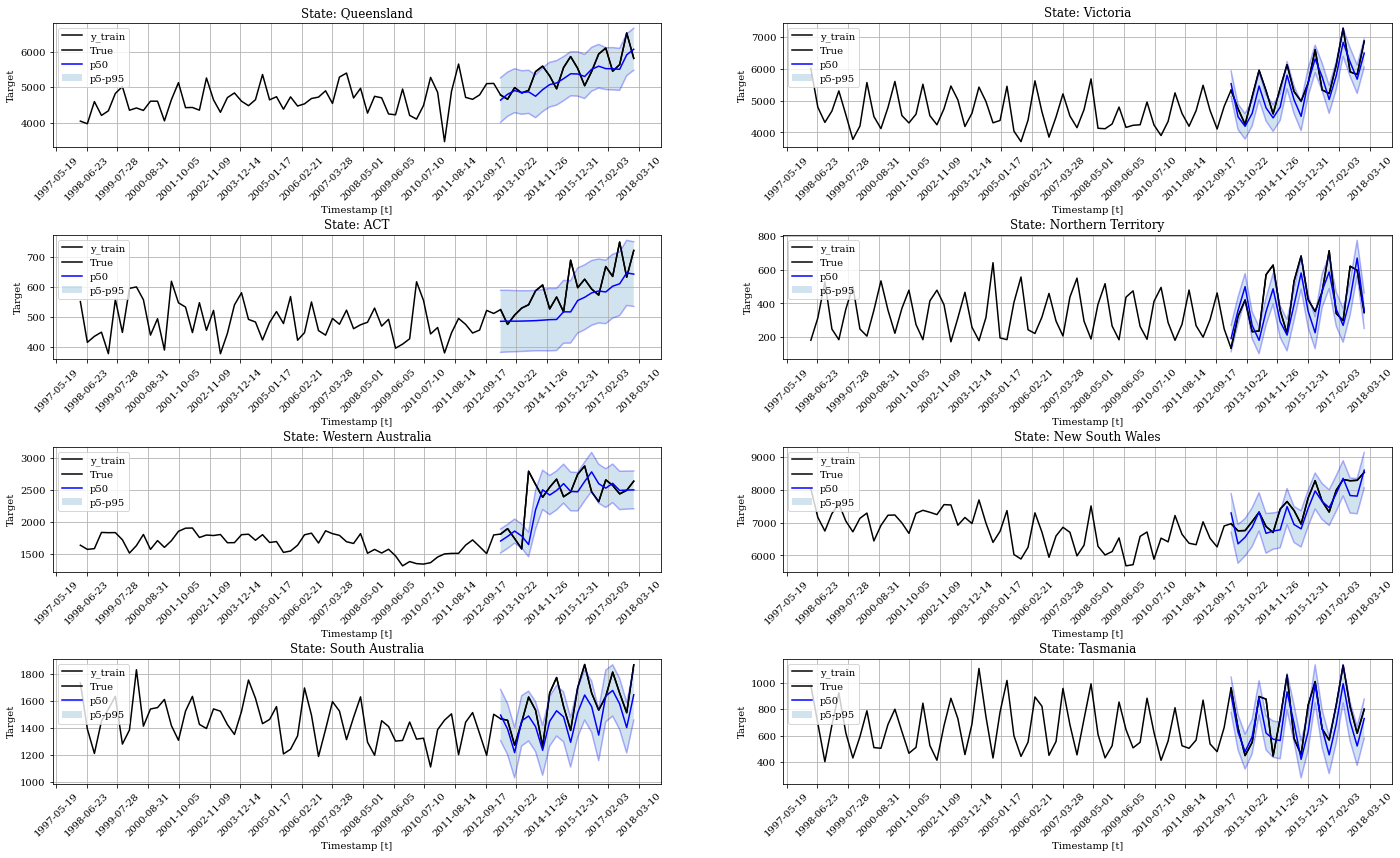

In [29]:
forecasts_cv.rename(
    columns={"AutoARIMA": "y_50", "AutoARIMA-lo-90": "y_5", "AutoARIMA-hi-90": "y_95"}, 
    inplace=True
)
plot_grid(tourism_df_agg, plot_titles=State_id, df_test=forecasts_cv)

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/examples/CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>